# Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques (sujet 4)

## Introduction

Pour notre analyse sur les caractéristiques d'une connexion nous utiliserons un modèle simplifié qui néglige certains détails.
Ce modèle permet de mettre en relation le **temps d'envoi $T$** (en secondes) d'un message de **taille $S$** (en octets) par une connexion de **latence $L$** (en secondes) et de **capacité $C$** (en octets/seconde) par la formule suivante : $$T(S) = L + S/C$$

Nous allons donc tenter de déterminer la latence et la capacité d'une connection à partir de deux jeux de données brutes, qui ont été obtenus pour deux connexions différentes avec l'outil `ping`.

## Analyse des données

### Dépendances

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

### 1. Connexion courte à l'intérieur d'un campus

#### Récupération et formatage des données

In [2]:
raw_data_1 = pd.read_csv("http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz",sep=' ',header=None)

Les données brutes sont stockées dans une variable `raw_data_1`

In [3]:
def convert_date(raw_date,start):
    return float(raw_date[1:-1])-start

def convert_size(raw_size):
    return int(raw_size)

def convert_time(raw_time):
    if(pd.isna(raw_time)):
        return None
    return float(raw_time[5:])

def format_data(raw_data):
    output_data = {}
    first_date = math.floor(float(raw_data[0][0][1:-1]))
    output_data["date"] = [convert_date(d,first_date) for d in raw_data[0]]
    output_data["size"] = [convert_size(s) for s in raw_data[1]]
    output_data["time"] = [convert_time(t) for t in raw_data[8]]
    i=0
    while (i<len(output_data["time"])):
        if(output_data["time"][i]==None):
            del output_data["date"][i]
            del output_data["size"][i]
            del output_data["time"][i]
        else:
            i += 1
    return output_data

data_1 = format_data(raw_data_1)

Les données brutes sont formatée pour obtenir la date, la taille et le temps d'envoi de chaque mesure.

#### Temps de transmission en fonction du temps

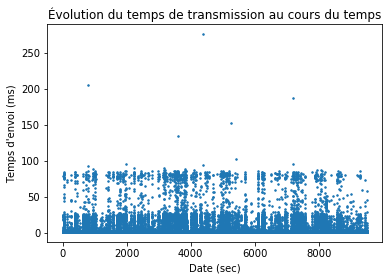

In [4]:
def display_graph_1(data,start=0,end=-1,m=1.5):
    plt.plot(data["date"][start:end],data["time"][start:end], 'o', markersize=m)
    plt.xlabel("Date (sec)")
    plt.ylabel("Temps d'envoi (ms)")
    plt.title("Évolution du temps de transmission au cours du temps")
    plt.show()

display_graph_1(data_1)

L'évolution du temps de transmission est représenté ici sur toute la plage de données.
On constate une tendance du temps de transmission entre 50ms et 100ms ne dépassant que rarement les 100ms.
Mais la majorité des valeurs de temps d'envoi semble répartie entre 0ms et 25ms.
Cependant on constate également que cette valeur est très variable. Elle est très éparpillée entre 0ms et 100ms avec des pics à plus de 250ms.
Il est probable que ces fluctuations ne soient pas seulement dûes à la taille des messages mais également à d'autres paramètres extérieurs que nous ne prenons pas en compte ici.

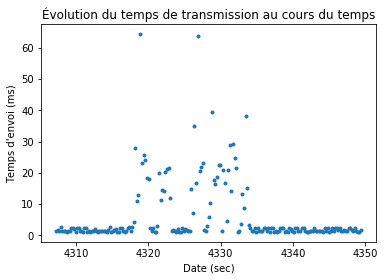

In [5]:
display_graph_1(data_1,20120,20320,3)

En observant ici les données sur une échelle plus petite, on constate le même phénomène de fluctuation importante du temps de transmission.

#### Temps de transmission en fonction de la taille des messages

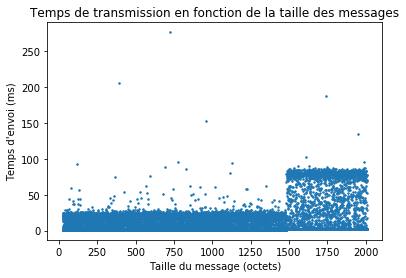

In [6]:
def sort_by_size(data):
    return zip(*sorted(zip(data["size"],data["time"])))

x, y = sort_by_size(data_1)

def display_graph_2(x,y,start=0,end=-1,m=1.5):
    plt.plot(x[start:end],y[start:end],'o', markersize=m)
    plt.xlabel("Taille du message (octets)")
    plt.ylabel("Temps d'envoi (ms)")
    plt.title("Temps de transmission en fonction de la taille des messages")
    plt.show()

display_graph_2(x,y)

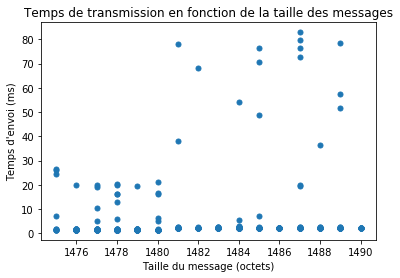

In [7]:
display_graph_2(x,y,32550,32850,5)

On observe une rupture dans le graphique aux alentours de 1500 octets.
En utilisant une échelle plus petite, on peut estimer que la taille à partir de laquelle la variabilité change est 1481 octets.
On va donc traiter ces deux classes séparément.

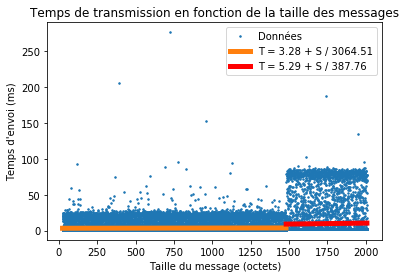

In [8]:
def display_graph_3(x,y):
    v_change = x.index(1481)
    x1 = np.array(x[:v_change])
    y1 = y[:v_change]
    x2 = np.array(x[v_change:])
    y2 = y[v_change:]

    reg1=np.polyfit(x1,y1,1)
    reg2=np.polyfit(x2,y2,1)

    L1 = reg1[1]
    C1 = 1/reg1[0]
    L2 = reg2[1]
    C2 = 1/reg2[0]

    plt.plot(x, y,'o',markersize=1.5, label='Données')
    plt.plot(x1,reg1[0]*x1+reg1[1],linewidth=5,label=f"T = {L1:.2f} + S / {C1:.2f}")
    plt.plot(x2,reg2[0]*x2+reg2[1],'r',linewidth=5,label=f"T = {L2:.2f} + S / {C2:.2f}")
    plt.xlabel("Taille du message (octets)")
    plt.ylabel("Temps d'envoi (ms)")
    plt.title("Temps de transmission en fonction de la taille des messages")
    plt.legend()
    plt.show()
    return {"L1":L1,"C1":C1,"L2":L2,"C2":C2}

vals = display_graph_3(x,y)

Pour les messages de moins de 1481 octets, on a donc :

In [9]:
print(f"L = {vals['L1']} ms\t= {vals['L1']/1000} s")
print(f"C = {vals['C1']} o/ms\t= {vals['C1']*1000} o/s")

L = 3.275674199393942 ms	= 0.003275674199393942 s
C = 3064.514616898644 o/ms	= 3064514.616898644 o/s


Et pour les messages de plus de 1481 octets, on a :

In [10]:
print(f"L = {vals['L2']} ms\t= {vals['L2']/1000} s")
print(f"C = {vals['C2']} o/ms\t= {vals['C2']*1000} o/s")

L = 5.289832573707131 ms	= 0.005289832573707131 s
C = 387.7603997848882 o/ms	= 387760.3997848882 o/s


### 2. Connexion vers un site Web éloigné

#### Récupération et formatage des données

In [11]:
raw_data_2 = pd.read_csv("http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz",sep=' ',header=None)
data_2 = format_data(raw_data_2)

#### Temps de transmission en fonction du temps

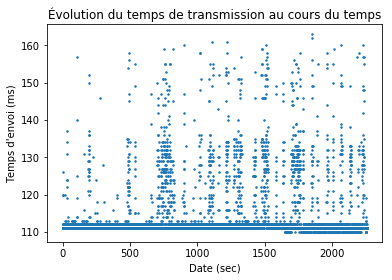

In [12]:
display_graph_1(data_2)

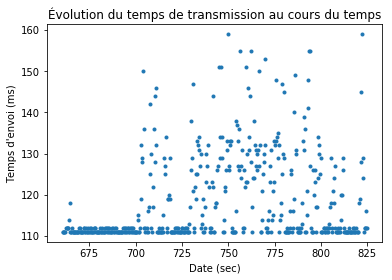

In [13]:
display_graph_1(data_2,2000,2500,3)

Ici le temps d'envoi moyen avoisine les 110ms. Aucune valeur ne descend en dessous de ce seuil, mais une partie importante des données est dispersées entre 110ms et 160ms.

#### Temps de transmission en fonction de la taille des messages

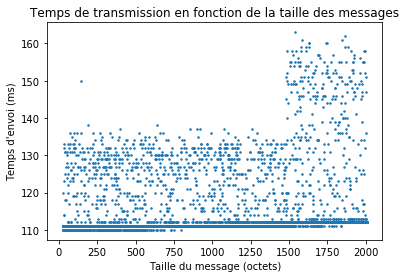

In [14]:
x, y = sort_by_size(data_2)
display_graph_2(x,y)

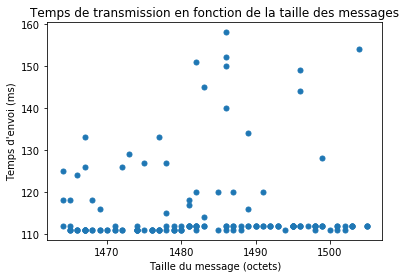

In [15]:
display_graph_2(x,y,4950,5100,5)

On constate également un point de rupture qui apparait aux alentours de 1500 octets. Après observation des données à plus petite échelle, on peut conjecturer qu'il se trouve également à 1481 octets.

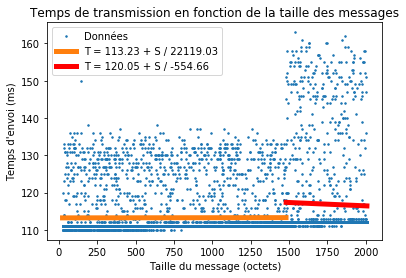

In [16]:
vals_2 = display_graph_3(x,y)

Pour les messages de moins de 1481 octets, on a donc :

In [17]:
print(f"L = {vals_2['L1']} ms\t= {vals_2['L1']/1000} s")
print(f"C = {vals_2['C1']} o/ms\t= {vals_2['C1']*1000} o/s")

L = 113.22750968484876 ms	= 0.11322750968484875 s
C = 22119.029139909035 o/ms	= 22119029.139909036 o/s


Et pour les messages de plus de 1481 octets, on a :

In [18]:
print(f"L = {vals_2['L2']} ms\t= {vals_2['L2']/1000} s")
print(f"C = {vals_2['C2']} o/ms\t= {vals_2['C2']*1000} o/s")

L = 120.05358833473097 ms	= 0.12005358833473098 s
C = -554.663121159614 o/ms	= -554663.121159614 o/s
